# MCTS TO-DO
Implement a Monte-Carlo Tree Search Agent that selects actions based on reward to replicate Three Sisters.

 *Goals*
- edit environment so it is not random i.e. agent choose to location of plants
- define policy to select state
- define how to evalulate a simulation
- return best simulation and fine tune

*Sunday 2/27*
- Define basic agent that uses Adam's value function
- Get agent to return best simulation


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from enum import Enum

class Plant:
    def __init__(self, species, maturity=110):
        self.species = species
        self.maturity = maturity         # consider 'days_to_maturity'
        self.age = 0
        
    def __repr__(self):
        return "{}".format(self.species)
    

class Field(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, size=5, sow_limit=200, season=120, calendar=0):
        # parameters for overall field character
        self.size = size
        self.sow_limit = sow_limit
        self.season = season
        self.calendar = calendar
        
        # constants for computing end-of-season reward---distances represent meters
        self.crowding_dist = .02
        self.maize_maize_dist = .1
        self.bean_support_dist = .1
        self.crowding_penalty = .1
        self.maize_maize_penalty = .9
        self.bean_support_bonus = .6
        
        # OpenAI action and observation space specifications
        self.action_space = spaces.Discrete(4)
        ### self.observation_space = spaces.???
        
        # field is initialized by calling reset()
        self.field = None
        
    def step(self, action):
        # sow plants (or wait) depending on actions chosen
        # action is an array of n choices; value of n specified in agent code sow_limit
        # could be cleaned up with plants as an enumeration?
        
        for choice in action:
            if choice == 0:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Maize')]], axis=0)
            elif choice == 1:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Bean')]], axis=0)
            elif choice == 2:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Squash')]], axis=0)
            # when choice == 3, nothing is done (agent waits)   
            
        
        # increment timekeeping
        self.calendar +=1
        for plant in self.field:
            plant[2].age += 1
            
        done = self.calendar == self.season
            
        if not done:
            reward = 0
        else:
            reward = self.get_reward()
            
        return self.field, reward, done, {}
    
    def reset(self):
        # field is initialized with one random corn plant in order to make sowing (by np.append) work
        self.field = np.array([[self.size * np.random.random(), 
                                self.size * np.random.random(), 
                                Plant('Maize')]])
        # timekeeping is reset
        self.calendar = 0
        
    def render(self, mode='human'):
        # initialize plant type arrays so that pyplot won't break if any is empty
        maize = np.array([[None, None]])
        bean = np.array([[None, None]])
        squash = np.array([[None, None]])
        maize_imm = np.array([[None, None]])
        bean_imm = np.array([[None, None]])
        squash_imm = np.array([[None, None]])
        
        # replace initial arrays with coordinates for each plant type; imm are plants that haven't matured
        maize = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age >= row[2].maturity])
        bean = np.array([row for row in self.field 
                            if row[2].__repr__() == 'Bean' and row[2].age >= row[2].maturity])
        squash = np.array([row for row in self.field 
                              if row[2].__repr__() == 'Squash' and row[2].age >= row[2].maturity])
        maize_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age < row[2].maturity])
        bean_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Bean' and row[2].age < row[2].maturity])
        squash_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Squash' and row[2].age < row[2].maturity])
        
        # plot the field---currently breaks if any plant type is absent
        plt.figure(figsize=(10, 10))
        plt.scatter(maize[:,0], maize[:,1], c='green', s=200, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(bean[:,0], bean[:,1], c='brown', s=150, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(squash[:,0], squash[:,1], c='orange', s=400, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(maize_imm[:,0], maize_imm[:,1], c='green', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(bean_imm[:,0], bean_imm[:,1], c='brown', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(squash_imm[:,0], squash_imm[:,1], c='orange', s=200, marker = 'o', alpha=.1, edgecolor='#303030')

        plt.show()
        
        print("Total yield in Calories is {}.\n---\n".format(round(reward, 1)))
    
    def close(self):
        # unneeded right now? AFAICT this is only used to shut down realtime movie visualizations
        pass
    
    def get_reward(self):
        # array of plant coordinates for computing distances
        xy_array = np.array([[row[0], row[1]] for row in self.field])

        # distances[m,n] is distance from mth to nth plant in field
        distances = np.linalg.norm(xy_array - xy_array[:,None], axis=-1)
        
        reward = 0
        i = 0
        while i < len(self.field):
            if self.field[i,2].age < self.field[i,2].maturity:
                reward += 0
            elif self.field[i,2].__repr__() == 'Maize':
                cal = 1
                j = 0
                while j < len(distances[0]):
                    if (self.field[j,2].__repr__() == 'Bean' 
                            and distances[i,j] < self.bean_support_dist):
                        cal += self.bean_support_bonus
                    if (self.field[j,2].__repr__() == 'Maize' 
                            and i !=j 
                            and distances[i,j] < self.maize_maize_dist):
                        cal *= self.maize_maize_penalty
                    if 0 < distances[i,j] < self.crowding_dist:
                        cal *= self.crowding_penalty
                    j += 1
                reward += cal
            elif self.field[i,2].__repr__() == 'Bean':
                reward += .25
            elif self.field[i,2].__repr__() == 'Squash':
                reward += 3
            i += 1        
        return reward


In [ ]:
class state:
    def __init__(self, field, action, pred, term):
        self.field = field  
        self.action = action
        self.pred = pred
        self.children = []
        self.isTerminal =  term
        # calculating heuristic
        self.val = 0 # value of a node i 
        self.avg = 0 # empirical mean of a node i 
        self.c = 1 # constant for UCB 
        self.t = 1 # total number of simulations
        # may need to add more datamembers 
    def setTerm(self, bool):
        self.isTerminal = bool
    def visit(self):
        self.t +=1
    def getUCCB(self): # use val, avg, c, t to calculate and return UCB
        return 0



In [ ]:
class mcts_agent:
    def __init__(self, root, term):
        self.root = root # starting field i.e. empty field
        self.tree = {} # holds all node states, may not need
        self.term = term # end of season, i.e how many nodes to expand
        # may need more data members
    def select(self, state, field): # chooses move based on state
        return state.select_bandit()
    def rollout(self, field): # runs monte carlo simulation by picking random moves from root to terminal, will call backprop()
        i = 0
        state curr = self.root
        while i < self.term:        
            #randomly select an action and make a new state
            action = ()
            new = state(field, action, curr, False)
            curr = new
            curr.setTerm(True)
            backbrop()
        return
    def backprop(self, state): # updates heuristic (UCB)
        return


In [ ]:
# pseudocode: https://www.geeksforgeeks.org/ml-monte-carlo-tree-search-mcts/
#  def monte_carlo_tree_search(root):
     
#     while resources_left(time, computational power):
#         leaf = traverse(root)
#         simulation_result = rollout(leaf)
#         backpropagate(leaf, simulation_result)
         
#     return best_child(root)
 
# # function for node traversal
# def traverse(node):
#     while fully_expanded(node):
#         node = best_uct(node)
         
#     # in case no children are present / node is terminal
#     return pick_unvisited(node.children) or node
 
# # function for the result of the simulation
def rollout(node):
#     while non_terminal(node):
#         node = rollout_policy(node)
#     return result(node)
 
# # function for randomly selecting a child node
# def rollout_policy(node):
#     return pick_random(node.children)
 
# # function for backpropagation
# def backpropagate(node, result):
#     if is_root(node) return
#     node.stats = update_stats(node, result)
#     backpropagate(node.parent)
 
# # function for selecting the best child
# # node with highest number of visits
# def best_child(node):
#     pick child with highest number of visits

Results after 0 trials:


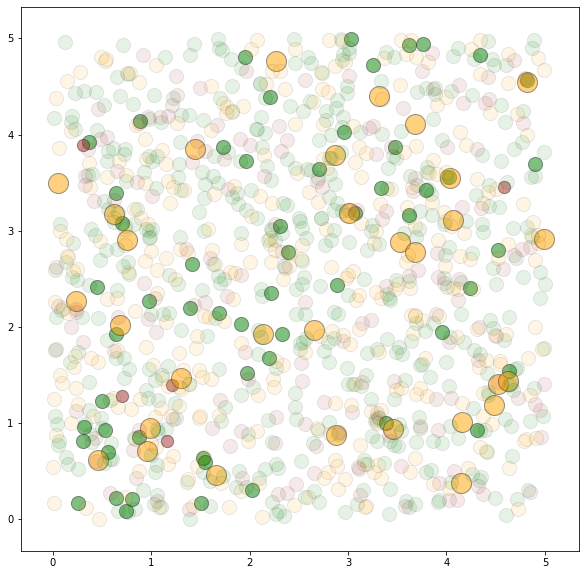

Total yield in Calories is 152.9.
---

Results after 20 trials:


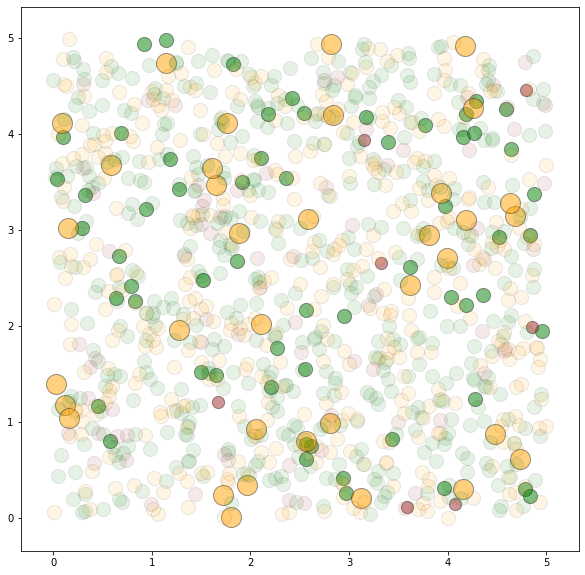

Total yield in Calories is 162.3.
---

Results after 40 trials:


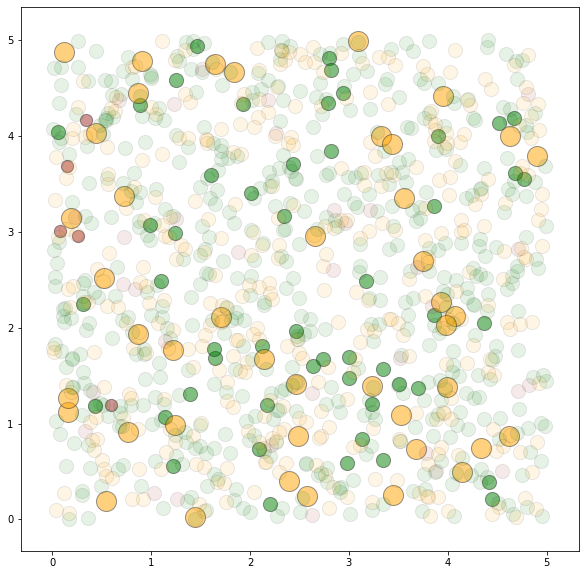

Total yield in Calories is 176.8.
---

Results after 60 trials:


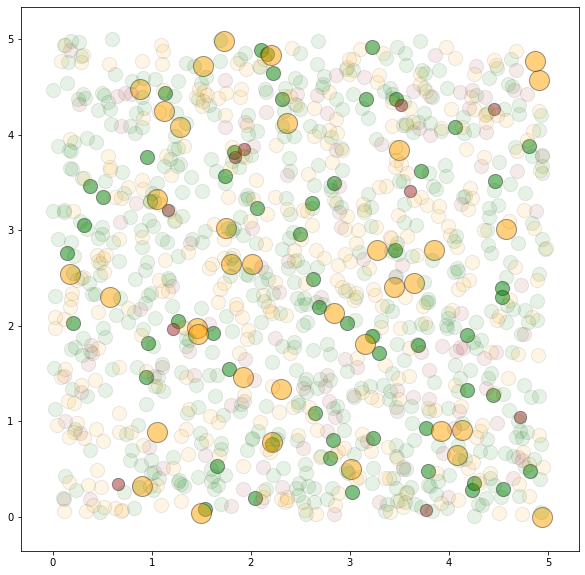

Total yield in Calories is 165.5.
---

Results after 80 trials:


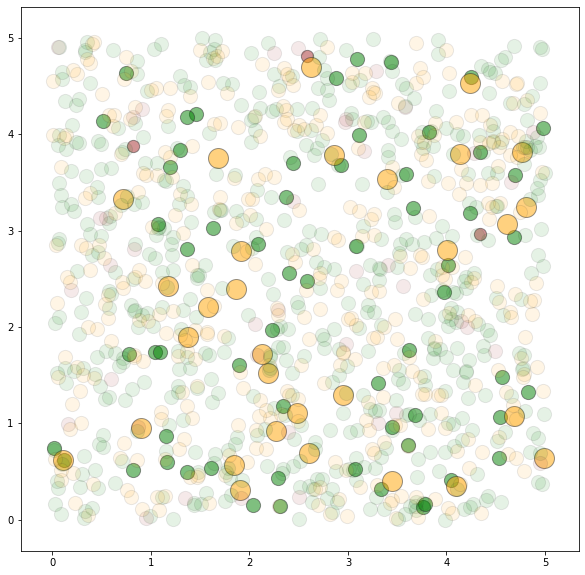

Total yield in Calories is 143.9.
---

Results after 100 trials:
Best weights discovered are: 
	sow maize 	0.45007643088866506 
	sow bean 	0.06858586466516349 
	sow squash 	0.36460229355663054        
	wait 		0.11673541088954088


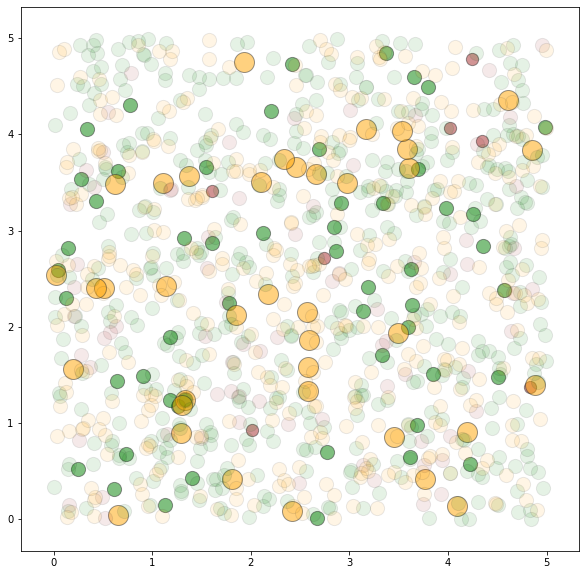

Total yield in Calories is 165.4.
---



In [3]:
# second agent: biased search in weight space

import gym
import numpy as np

# global parameters for trials
testbed = Field()
best_weights = np.random.dirichlet(np.ones(4))
best_yield = 0
yield_history = []
sow_limit = 10
num_trials = 100

# for storing subplots
subplots = []

#--- second agent essentially does random grid search to optimize hyper parameters ---#
#--- we want to use monte carlo tree search over a much larger search space to optimize results ---# 
#--- we may also want to adjust environment so "game" is not random ---#


bestMCTS = monte_carlo_tree_search(field)
# goal --> replicate three sisters crop
# for i in range(num_trials): # simulation 
    
#     # initialize trial
#     observation = testbed.reset()
#     done = False
#     count = 0
    
#     # calculate step vector for random walk
#     epsilon = np.random.random(1) / 20
#     delta = epsilon * np.random.permutation([1, 1, -1, -1])
    
#     while not done:
#         count += 1
#         # ensure step won't take agent outside of weight space
#         while True in ((best_weights + delta) < 0):
#             epsilon = np.random.random(1) / 20
#             delta = epsilon * np.random.permutation([1, 1, -1, -1])
#         weights = best_weights + delta
#         action = [np.random.choice(4, p=weights) for i in range(sow_limit)]
#         observation, reward, done, _ = testbed.step(action)
        
#         if done:   
#             yield_history.append(round(reward))
#             if reward > best_yield:
#                 best_yield = reward
#                 best_weights = weights
                
#     if i % 20 == 0:
#         print("Results after {} trials:".format(i))
#         subplot = testbed.render()
#         # subplots.append(subplot) # attempting to get a six-in-one figure


# run a final trial using the best weights discovered
observation = testbed.reset()
done = False

#--- back track with optimal results ( replace how this is done ) ---#
while not done:
    weights = bestMCTS
    action = [np.random.choice(4, p=best_weights) for i in range(sow_limit)]
    observation, reward, done, _ = testbed.step(action)
    


#--- interface with environment, displaying rewsults ---#
# show results
print("Results after {} trials:".format(num_trials))
#print("Yield history is: ", yield_history)
#print(best_yield)
print("Best weights discovered are: \n\tsow maize \t{} \n\tsow bean \t{} \n\tsow squash \t{} \
       \n\twait \t\t{}".format(best_weights[0], best_weights[1], best_weights[2], best_weights[3]))
            
testbed.render()
#print(subplots)


Results after 0 trials:
Current sow limit: 


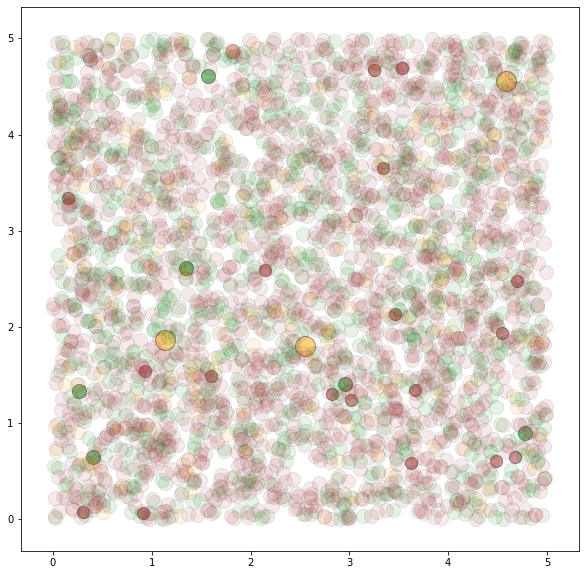

Total yield in Calories is 27.5.
---



In [ ]:
# third agent: biased search in weight space that can observe time
# OR MAYBE just try to write a new agent that not only adjusts weights but also sow limit

import gym
import numpy as np

# global parameters for episodes
testbed = Field()
best_weights = np.random.dirichlet(np.ones(4))
best_yield = 0
yield_history = []
sow_limit = 10
num_trials = 100

# for storing subplots
subplots = []


# does a random walk in weight+sow_limit space and keeps any step that improves yield
for i in range(num_trials):
    
    # initialize trial
    observation = testbed.reset()
    done = False
    count = 0
    
    # calculate step vector for random walk
    epsilon = np.random.random(1) / 20
    delta = epsilon * np.random.permutation([1, 1, -1, -1])
    
    # calculate step for sow_limit walk
    sigma = np.random.randint(-2, 3)
    
    while not done:
        count += 1
        
        # ensure step won't take agent outside of weight space
        while True in ((best_weights + delta) < 0):
            epsilon = np.random.random(1) / 20
            delta = epsilon * np.random.permutation([1, 1, -1, -1])
            
        # ensure step won't take sow_limit below 0
        while sow_limit + sigma < 0:
            sigma = np.random.randint(-2, 3)
        
        weights = best_weights + delta
        sow_limit += sigma
        action = [np.random.choice(4, p=weights) for i in range(sow_limit)]
        observation, reward, done, _ = testbed.step(action)
        
        if done:
            yield_history.append(round(reward))
            if reward > best_yield:
                best_yield = reward
                best_weights = weights
                
    if i % 20 == 0:
        print("Results after {} trials:".format(i))
        print("Current sow limit: ".format(sow_limit))
        subplot = testbed.render()
        # subplots.append(subplot) # attempting to get a six-in-one figure


# run a final trial using the best weights discovered
observation = testbed.reset()
done = False
while not done:
    weights = best_weights
    action = [np.random.choice(4, p=best_weights) for i in range(sow_limit)]
    observation, reward, done, _ = testbed.step(action)
    

# show results
print("Results after {} trials:".format(num_trials))
#print("Yield history is: ", yield_history)
#print(best_yield)
print("Best weights discovered are: \n\tsow maize \t{} \n\tsow bean \t{} \n\tsow squash \t{} \
       \n\twait \t\t{}".format(best_weights[0], best_weights[1], best_weights[2], best_weights[3]))
print("Best sow_limit discovered is {}.".format(sow_limit))
            
testbed.render()
#print(subplots)
